This script creates new features, selects relevant features for daily-level data, aggregates data to daily granularity, and performs more exploratory data analysis.

Note: This script contains the key steps for reproducibility and verifiability of results.
The complete process involved extensive data exploration and visualization. For the full analysis, please refer to 
"6) Feature Engineering and Selection" in the 'full-code' folder. 

Data source:
- Preprocessed data: '5) final_merged_data_imputed.csv'

In [1]:
import pandas as pd
import numpy as np
import holidays
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

df_final = pd.read_csv('5) final_merged_data_imputed.csv', parse_dates=['timestamp'])
print(df_final.columns)

Index(['household_id', 'timestamp', 'consumption', 'tariff',
       'washing_machine_fixed_schedule', 'tumble_dryer_fixed_schedule',
       'dishwasher_fixed_schedule', 'immersion_water_heater_fixed_schedule',
       'electric_oven_fixed_schedule', 'electric_hob_fixed_schedule',
       'ironing_fixed_schedule', 'electric_shower_fixed_schedule',
       'kettle_fixed_schedule', 'lighting_fixed_schedule',
       'electric_heater_fixed_schedule', 'washer-dryer_combined_timer_use',
       'washing_machine_timer_use', 'tumble_dryer_timer_use',
       'dishwasher_timer_use', 'electric_space_heating_timer_use',
       'washer-dryer_combined_ownership', 'washing_machine_ownership',
       'tumble_dryer_ownership', 'dishwasher_ownership',
       'electric_space_heating_ownership', 'household_size', 'male_occupants',
       'female_occupants', 'count_children', 'count_adult', 'ownership_owned',
       'ownership_rented', 'ownership_other', 'work_from_home',
       'housing_house', 'housing_apartm

In [2]:
# First, drop 'housing_mobile' (mutually exclusive, one-hot encoded variable) to avoid multicollinearity
df_final.drop('housing_mobile', axis=1, inplace=True)

### Functions to create new features

In [3]:
def create_daily_features(df):
    df['date'] = df['timestamp'].dt.date

    # Find the timestamp of peak consumption for each day
    peak_times = df.loc[df.groupby(['household_id', 'date'])['consumption'].idxmax()]
    peak_times = peak_times[['household_id', 'date', 'timestamp', 'temp', 'humidity', 'windspeed', 'precip', 'solarradiation', 'tariff']]
    
    # Map tariff values to categorical labels
    tariff_mapping = {0.0399: 0, 0.1176: 1, 0.6720: 2}
    peak_times['tariff'] = peak_times['tariff'].map(tariff_mapping)
    
    peak_times.columns = ['household_id', 'date', 'peak_time'] + [f'{col}_at_peak_consumption_today' for col in ['temp', 'humidity', 'windspeed', 'precip', 'solarradiation']] + ['tariff_at_peak_consumption_today']

    # Aggregate daily data
    daily_agg = df.groupby(['household_id', 'date']).agg({
    'consumption': ['sum', 'max', 'min'], 
    'temp': ['min', 'max', 'mean'],
    'humidity': ['min', 'max', 'mean'],
    'windspeed': ['mean', 'max', 'min'], 
    'precip': 'sum',
    'solarradiation': 'sum'
    })

    # Flatten column names
    daily_agg.columns = ['_'.join(col).strip() for col in daily_agg.columns.values]
    daily_agg.reset_index(inplace=True)

    daily_agg.rename(columns={
        'consumption_sum': 'consumption_sum_today',
        'consumption_max': 'consumption_peak_today',
        'consumption_min': 'consumption_min_today',
        'temp_min': 'temp_min_today',
        'temp_max': 'temp_max_today',
        'temp_mean': 'temp_mean_today',
        'humidity_min': 'humidity_min_today',
        'humidity_max': 'humidity_max_today',
        'humidity_mean': 'humidity_mean_today',
        'windspeed_mean': 'windspeed_mean_today',
        'windspeed_max': 'windspeed_max_today',
        'windspeed_min': 'windspeed_min_today',
        'precip_sum': 'precip_sum_today',
        'solarradiation_sum': 'solarradiation_sum_today'
    }, inplace=True)

    # Create price features
    price_features = df.groupby(['household_id', 'date', 'tariff']).size().unstack(fill_value=0)
    price_features.reset_index(inplace=True)

    # Rename price duration columns
    price_features = price_features.rename(columns={
        0.0399: 'low_price_duration',
        0.1176: 'normal_price_duration',
        0.6720: 'high_price_duration'
    })

    # Merge aggregated data with price features and peak time features
    daily_df = daily_agg.merge(price_features, on=['household_id', 'date'])
    daily_df = daily_df.merge(peak_times, on=['household_id', 'date'])

    # Identify the first day for each household since the first day only has entries for 23 hours
    daily_df['is_first_day'] = daily_df.groupby('household_id')['date'].transform('min') == daily_df['date']

    # Set denominator for proportion calculation (23 for first day, 24 for all other days)
    daily_df['hours_denominator'] = np.where(daily_df['is_first_day'], 23, 24)

    # Create proportions for prices
    for price_str in ['low', 'normal', 'high']:
        daily_df[f'prop_{price_str}_price'] = daily_df[f'{price_str}_price_duration'] / daily_df['hours_denominator']

    # Drop temporary and unnecessary columns
    columns_to_drop = ['is_first_day', 'hours_denominator', 'low_price_duration', 'normal_price_duration', 'high_price_duration']
    daily_df = daily_df.drop(columns=columns_to_drop)

    # Create consumption_peak_next_day feature
    daily_df['consumption_peak_next_day'] = daily_df.groupby('household_id')['consumption_peak_today'].shift(-1)

    return daily_df

def add_features(df):
    print("Initial shape:", df.shape)

    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(['date', 'household_id'])

    # Previous day's peak consumption
    df['prev_day_peak'] = df.groupby('household_id')['consumption_peak_today'].shift(1)

    # Peak consumption from same day last week
    df['same_day_last_week_peak'] = df.groupby('household_id')['consumption_peak_today'].shift(7)

    # Average peak consumption over past 3 and 7 days
    df['avg_peak_3d'] = df.groupby('household_id')['consumption_peak_today'].rolling(window=3).mean().reset_index(0, drop=True)
    df['avg_peak_7d'] = df.groupby('household_id')['consumption_peak_today'].rolling(window=7).mean().reset_index(0, drop=True)

    # For weekly patterns
    df['day_of_week'] = df['date'].dt.dayofweek

    # Maximum of daily peak consumption over past 7 days and 3 days
    df['max_peak_7d'] = df.groupby('household_id')['consumption_peak_today'].rolling(window=7).max().reset_index(0, drop=True)
    df['max_peak_3d'] = df.groupby('household_id')['consumption_peak_today'].rolling(window=3).max().reset_index(0, drop=True)

    # Daily temperature range
    df['temp_range_today'] = df['temp_max_today'] - df['temp_min_today']

    # Season (for London)
    def get_season(month):
        if month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        elif month in [9, 10, 11]:
            return 'Autumn'
        else:
            return 'Winter'
    df['season'] = df['date'].dt.month.map(get_season)

    # Create binary variables for each season (one-hot encoding). Exclude spring to avoid multicollinearity.
    df['is_summer'] = (df['season'] == 'Summer').astype(int)
    df['is_autumn'] = (df['season'] == 'Autumn').astype(int)
    df['is_winter'] = (df['season'] == 'Winter').astype(int)

    # Weekend and holiday indicators
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    uk_holidays = holidays.UK(years=2013)
    df['is_holiday'] = df['date'].isin(uk_holidays).astype(int)

    # Day of week sine and cosine transformation
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    # Week of month calculation
    df['week_of_month'] = df['date'].apply(lambda x: (x.day - 1) // 7 + 1)

    # Week of month sine and cosine transformation
    df['week_of_month_sin'] = np.sin(2 * np.pi * df['week_of_month'] / 4)
    df['week_of_month_cos'] = np.cos(2 * np.pi * df['week_of_month'] / 4)

    # Remove temporary columns
    df = df.drop(['day_of_week', 'week_of_month', 'peak_time', 'season'], axis=1)
    
    # Final sort
    df = df.sort_values(['date', 'household_id'])
    
    print("Final shape:", df.shape)
    print("Final columns:", df.columns)
    
    return df

In [4]:
# Create the daily DataFrame
daily_df = create_daily_features(df_final)
result_df = add_features(daily_df) 

Initial shape: (221920, 27)
Final shape: (221920, 42)
Final columns: Index(['household_id', 'date', 'consumption_sum_today',
       'consumption_peak_today', 'consumption_min_today', 'temp_min_today',
       'temp_max_today', 'temp_mean_today', 'humidity_min_today',
       'humidity_max_today', 'humidity_mean_today', 'windspeed_mean_today',
       'windspeed_max_today', 'windspeed_min_today', 'precip_sum_today',
       'solarradiation_sum_today', 'temp_at_peak_consumption_today',
       'humidity_at_peak_consumption_today',
       'windspeed_at_peak_consumption_today',
       'precip_at_peak_consumption_today',
       'solarradiation_at_peak_consumption_today',
       'tariff_at_peak_consumption_today', 'prop_low_price',
       'prop_normal_price', 'prop_high_price', 'consumption_peak_next_day',
       'prev_day_peak', 'same_day_last_week_peak', 'avg_peak_3d',
       'avg_peak_7d', 'max_peak_7d', 'max_peak_3d', 'temp_range_today',
       'is_summer', 'is_autumn', 'is_winter', 'is_weeke

In [5]:
# List of columns to exclude from static characteristics
exclude_columns = ['household_id', 'timestamp', 'tariff', 'consumption', 
                   'temp', 'humidity', 'windspeed', 'precip', 'solarradiation']

# Create a dataframe of static characteristics with one row per household
static_columns = [col for col in df_final.columns if col not in exclude_columns and col not in result_df.columns]
static_df = df_final[['household_id'] + static_columns].drop_duplicates(subset=['household_id'])

# Merge with static household characteristics
result_df = result_df.merge(static_df, on='household_id', how='left')
result_df = result_df.sort_values(['date', 'household_id'])

# After merge
print("\nColumns with NaN values:")
print(result_df.isnull().sum()[result_df.isnull().sum() > 0])


Columns with NaN values:
consumption_peak_next_day     608
prev_day_peak                 608
same_day_last_week_peak      4256
avg_peak_3d                  1216
avg_peak_7d                  3648
max_peak_7d                  3648
max_peak_3d                  1216
dtype: int64


# We will remove the days with missing values due to the creation of lagged variables and next day's peak consumption.

In [6]:
rows_before = result_df.shape[0]
print("Rows before dropping NaN values:", rows_before)

# Remove rows with NaN values
result_df = result_df.dropna()

rows_after = result_df.shape[0]
print("Rows after dropping NaN values:", rows_after)

Rows before dropping NaN values: 221920
Rows after dropping NaN values: 217056


# Next, we will convert the data type of variables to more appropriate ones.

In [7]:
id_and_date = ['household_id', 'date']

numerical_vars = ['consumption_peak_next_day', 'consumption_sum_today', 'consumption_peak_today', 'consumption_min_today',
                  'temp_max_today', 'temp_min_today', 'temp_mean_today', 'humidity_min_today', 'humidity_max_today', 'humidity_mean_today',
                  'windspeed_min_today', 'windspeed_max_today', 'windspeed_mean_today',
                  'precip_sum_today', 'solarradiation_sum_today', 'prop_low_price', 'prop_normal_price', 'prop_high_price',
                  'prev_day_peak', 'same_day_last_week_peak', 'avg_peak_3d', 'max_peak_3d', 'avg_peak_7d', 'max_peak_7d', 
                  'temp_range_today', 'tv_energy_score', 'smart_meter_interaction_score', 'total_refrigeration_units',
                  'day_of_week_sin', 'day_of_week_cos', 'week_of_month_sin', 'week_of_month_cos', 
                  'temp_at_peak_consumption_today', 'humidity_at_peak_consumption_today', 'windspeed_at_peak_consumption_today', 
                  'precip_at_peak_consumption_today', 'solarradiation_at_peak_consumption_today']

categorical_vars = ['work_from_home', 'interest_in_renewable_energy', 'interest_in_microgeneration', 
                    'climate_change_concern', 'lifestyle_environment', 'tariff_at_peak_consumption_today',
                    'smart_meter_bill_understanding', 'smart_meter_consumption_understanding'] + \
                   [col for col in result_df.columns if col.endswith('_timer_use')]

binary_vars = ['electric_central_heating', 'uses_electric_heater', 'is_weekend', 'is_holiday'] + \
              [col for col in result_df.columns if col.startswith('heating_')] + \
              [col for col in result_df.columns if col.endswith('_fixed_schedule')] + \
              [col for col in result_df.columns if col.startswith('ownership_')] + \
              [col for col in result_df.columns if col.startswith('housing_')] + \
              [col for col in result_df.columns if col.endswith('_ownership')] + \
              ['is_summer', 'is_autumn', 'is_winter']

count_vars = [
    'household_size', 'male_occupants', 'female_occupants', 'count_children', 'count_adult',
    'count_rooms', 'count_bedrooms', 'count_high_efficiency_bulbs', 'count_low_efficiency_bulbs', 
    'count_fluorescent_tubes', 'count_fridges_and_freezers', 
    'count_tv', 'count_cooking_appliances', 'count_laundry_appliances', 
    'count_kitchen_appliances', 'count_heating_water_appliances', 'count_entertainment_devices', 
    'count_computing_devices', 'count_energy_saving_devices'
]

In [8]:
def optimise_dtypes(df, id_and_date, numerical_vars, categorical_vars, binary_vars, count_vars):
    for col in df.columns:
        if col in id_and_date:
            continue  # Keep these as they are
        elif col in count_vars:
            df[col] = df[col].astype('uint16')
        elif col in numerical_vars:
            continue # Keep these as they are for higher precision
        elif col in categorical_vars:
            df[col] = df[col].astype('category')
        elif col in binary_vars:
            df[col] = df[col].astype('int')
        else:
            print(f"Warning: {col} not categorized")

    return df

# Apply the optimization
result_df = optimise_dtypes(result_df, id_and_date, numerical_vars, categorical_vars, binary_vars, count_vars)

# Print the new dtypes
print(result_df.dtypes)

household_id                                     object
date                                     datetime64[ns]
consumption_sum_today                           float64
consumption_peak_today                          float64
consumption_min_today                           float64
                                              ...      
interest_in_microgeneration                    category
climate_change_concern                         category
lifestyle_environment                          category
smart_meter_bill_understanding                 category
smart_meter_consumption_understanding          category
Length: 104, dtype: object


# Pearson Correlation Matrix

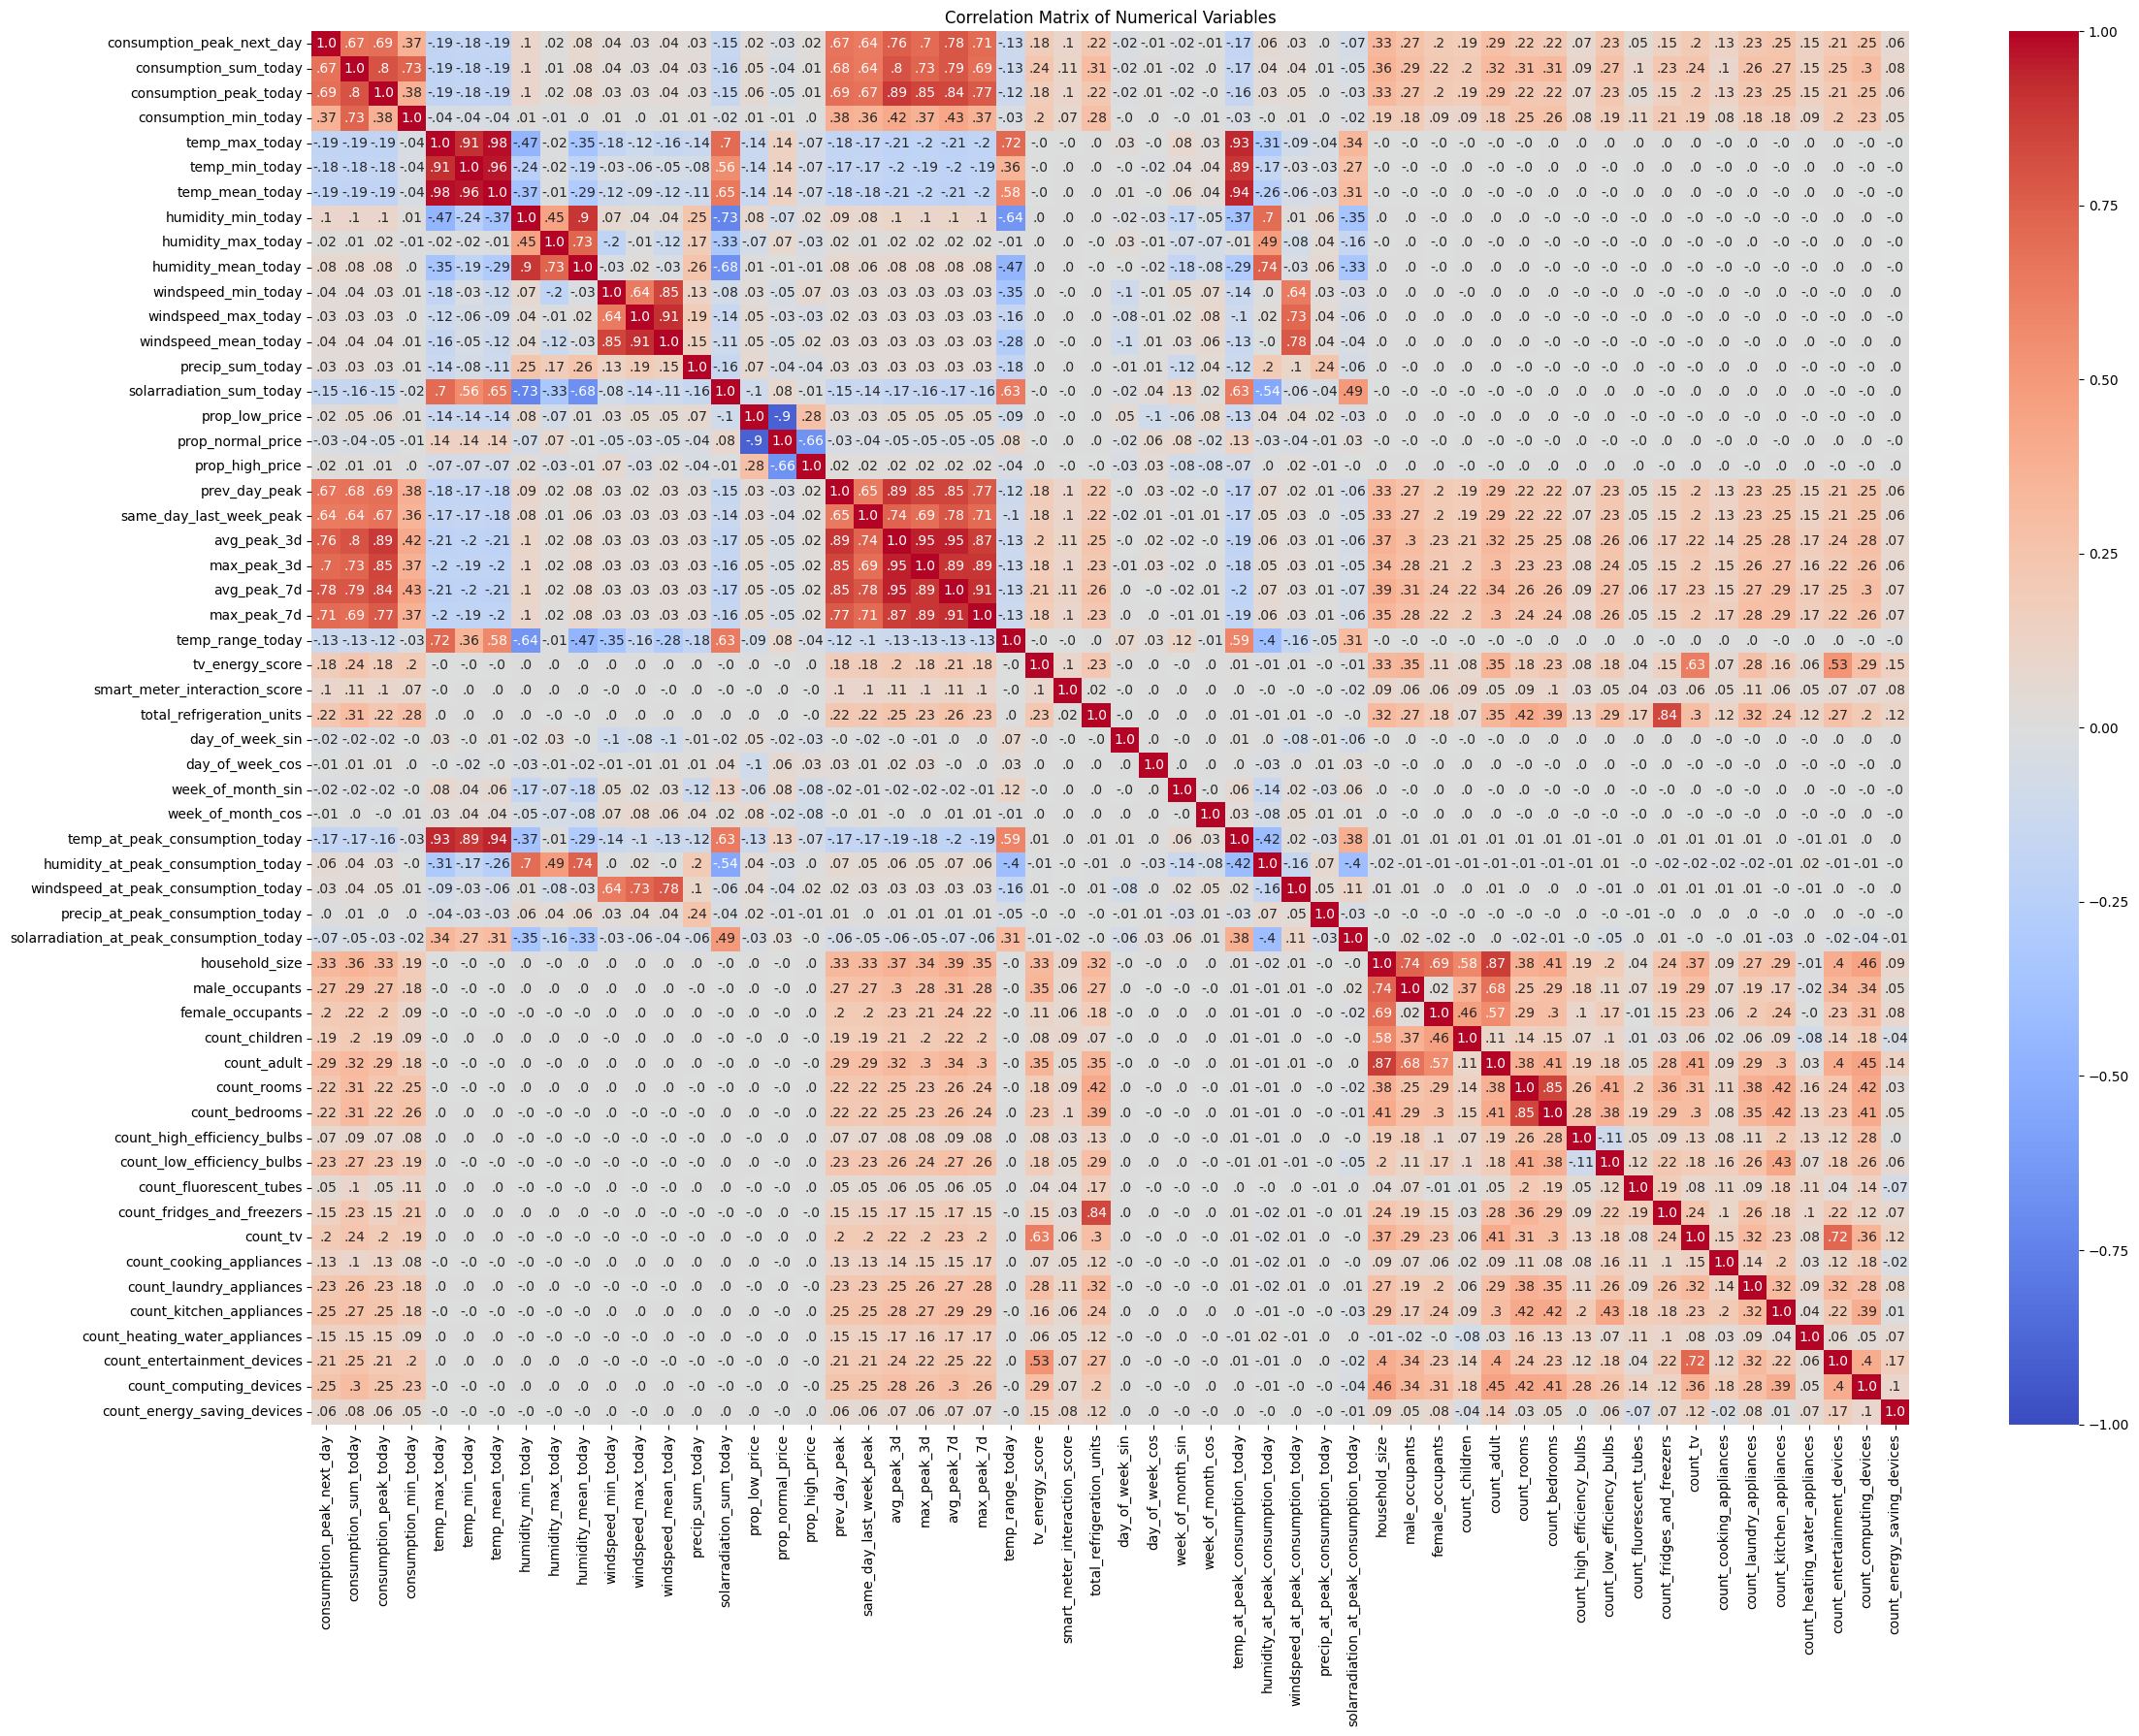

Highly correlated numerical features (correlation > 0.8):
consumption_peak_today and avg_peak_3d: 0.89
  Correlation with consumption_peak_next_day:
    consumption_peak_today: 0.69
    avg_peak_3d: 0.76

consumption_peak_today and max_peak_3d: 0.85
  Correlation with consumption_peak_next_day:
    consumption_peak_today: 0.69
    max_peak_3d: 0.70

consumption_peak_today and avg_peak_7d: 0.84
  Correlation with consumption_peak_next_day:
    consumption_peak_today: 0.69
    avg_peak_7d: 0.78

temp_max_today and temp_min_today: 0.91
  Correlation with consumption_peak_next_day:
    temp_max_today: -0.19
    temp_min_today: -0.18

temp_max_today and temp_mean_today: 0.98
  Correlation with consumption_peak_next_day:
    temp_max_today: -0.19
    temp_mean_today: -0.19

temp_max_today and temp_at_peak_consumption_today: 0.93
  Correlation with consumption_peak_next_day:
    temp_max_today: -0.19
    temp_at_peak_consumption_today: -0.17

temp_min_today and temp_mean_today: 0.96
  Correla

In [9]:
def process_numerical_correlations(df, numerical_vars, count_vars):
    def calculate_numerical_correlations(df, numerical_vars, count_vars):
        # Filter out variables not in the DataFrame
        valid_numerical_vars = [var for var in numerical_vars if var in df.columns]
        valid_count_vars = [var for var in count_vars if var in df.columns]
        
        # Select only the valid numerical variables
        num_df = df[valid_numerical_vars + valid_count_vars]
        
        # Calculate the correlation matrix
        corr_matrix = num_df.corr(method='pearson')
        
        return corr_matrix

    # Calculate correlations
    correlation_matrix = calculate_numerical_correlations(df, numerical_vars, count_vars)

    # Visualise the correlation matrix
    annot = correlation_matrix.round(2).astype(str)

    # Function to format the correlation values
    def format_corr(val):
        if val.startswith('-0.'):
            return '-' + val[2:]
        val = val.lstrip('0')
        if val == '.00' or val == '-.00':
            return '0'
        elif val.startswith('-.'):
            return '-' + val[2:]
        elif val == '.':
            return '0'
        return val

    # Apply the formatting function
    annot = annot.map(format_corr)

    plt.figure(figsize=(24, 18))  
    sns.heatmap(correlation_matrix, annot=annot, fmt='', cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix of Numerical Variables')
    plt.tight_layout()
    plt.savefig('numerical_correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Find highly correlated features
    high_corr_threshold = 0.8
    high_corr = np.where(np.abs(correlation_matrix) > high_corr_threshold)
    high_corr_list = [(correlation_matrix.index[x], correlation_matrix.columns[y], correlation_matrix.loc[correlation_matrix.index[x], correlation_matrix.columns[y]]) 
                      for x, y in zip(*high_corr) if x != y and x < y]

    print("Highly correlated numerical features (correlation > 0.8):")
    for feat1, feat2, corr in high_corr_list:
        print(f"{feat1} and {feat2}: {corr:.2f}")
        
        # Compare correlations with the target variable (consumption_peak_next_day)
        corr_feat1 = correlation_matrix.loc[feat1, 'consumption_peak_next_day']
        corr_feat2 = correlation_matrix.loc[feat2, 'consumption_peak_next_day']
        
        print(f"  Correlation with consumption_peak_next_day:")
        print(f"    {feat1}: {corr_feat1:.2f}")
        print(f"    {feat2}: {corr_feat2:.2f}")
        print()

    low_corr_threshold = 0.1
    low_corr_features = [
        col for col in correlation_matrix.columns 
        if abs(correlation_matrix.loc['consumption_peak_next_day', col]) < low_corr_threshold
    ]

    print("Features with correlation less than 0.1 with consumption_peak_next_day:")
    for feature in low_corr_features:
        print(f"{feature}: {correlation_matrix.loc['consumption_peak_next_day', feature]:.2f}")

process_numerical_correlations(result_df, numerical_vars, count_vars)

# Explore the correlation between temperature and peak consumption (of today and next day) further

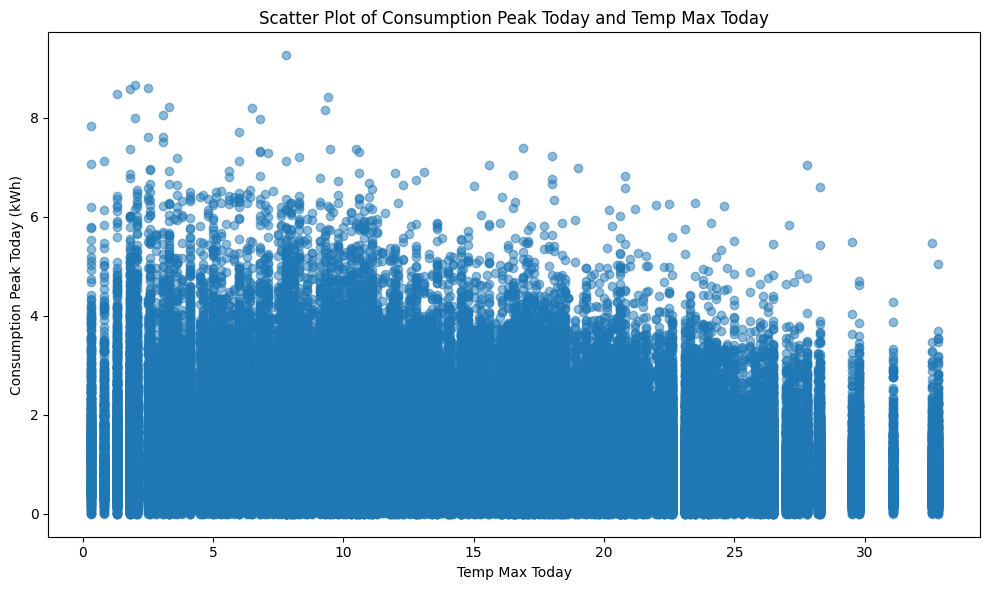

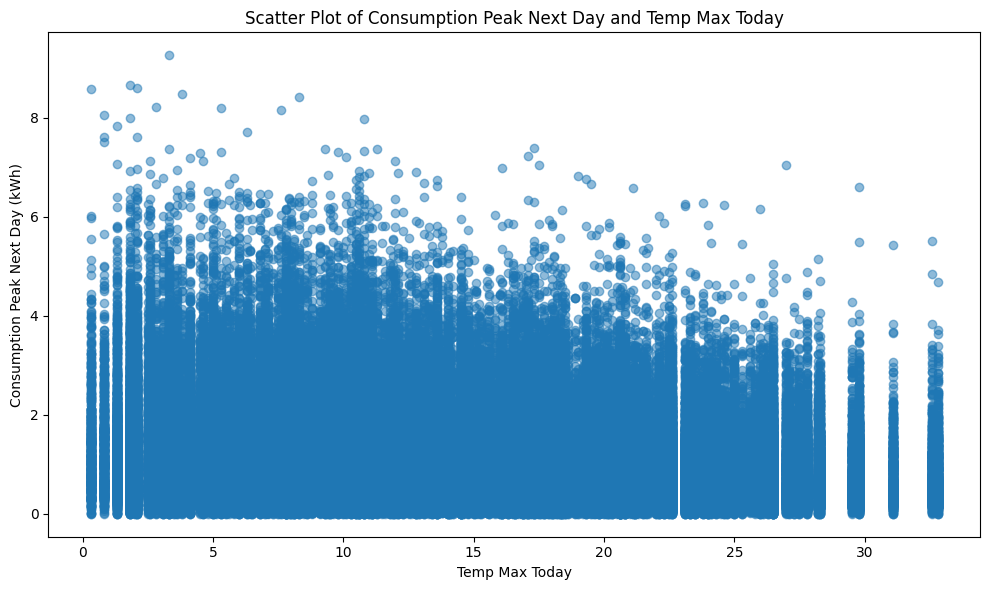

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(result_df['temp_max_today'], result_df['consumption_peak_today'], alpha=0.5)
plt.title('Scatter Plot of Consumption Peak Today and Temp Max Today')
plt.xlabel('Temp Max Today')
plt.ylabel('Consumption Peak Today (kWh)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(result_df['temp_max_today'], result_df['consumption_peak_next_day'], alpha=0.5)
plt.title('Scatter Plot of Consumption Peak Next Day and Temp Max Today')
plt.xlabel('Temp Max Today')
plt.ylabel('Consumption Peak Next Day (kWh)')
plt.tight_layout()
plt.show()

# Drop Redundant Features Based on Correlation Analysis

In [11]:
# We will keep 'consumption_peak_today', 'avg_peak_3d', 'max_peak_3d', 'avg_peak_7d', 'max_peak_7d' and 'prev_day_peak' despite high correlations as each feature likely provides valuable information for the next day's peak consumption
columns_to_drop = [
    'temp_min_today', 'temp_mean_today', 'temp_at_peak_consumption_today', 'humidity_mean_today', 'windspeed_mean_today', 
    'prop_normal_price', 'count_fridges_and_freezers', 'count_bedrooms', 'count_adult'
]

# As for features that have a low correlation with consumption_peak_next_day, we're only dropping household features because other features may have non-linear relationships not captured by the correlation coefficient.
columns_to_drop.extend([
    'smart_meter_interaction_score',
    'count_high_efficiency_bulbs',
    'count_fluorescent_tubes',
    'count_energy_saving_devices'
])

# Drop the selected columns from the DataFrame
result_df = result_df.drop(columns=columns_to_drop)

# Spearman's Rank Correlation and Mutual Information Plot

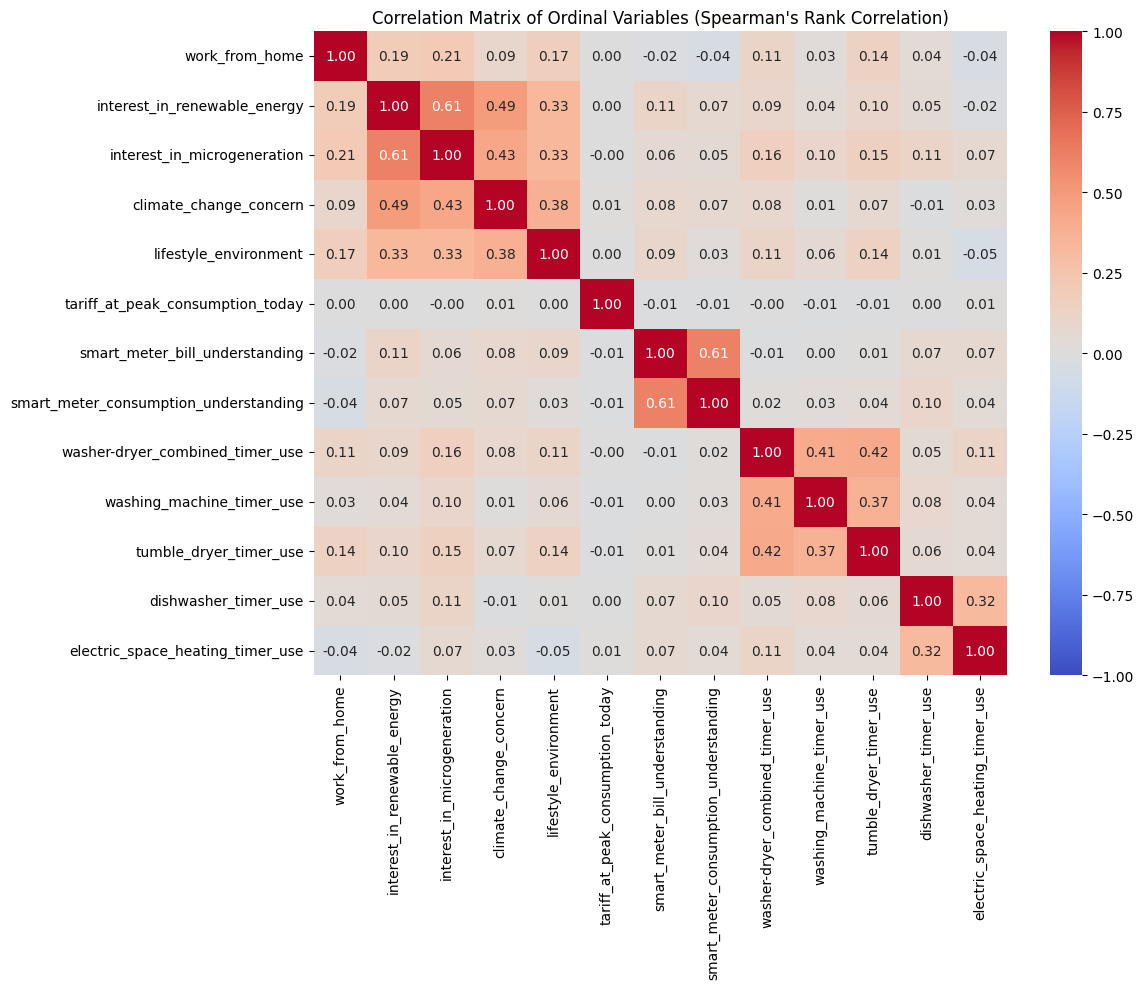

In [12]:
def spearman_correlation(x, y):
    try:
        return round(spearmanr(x, y)[0], 2)
    except:
        return np.nan

def ordinal_correlation_matrix(df, ordinal_vars):
    corr_matrix = pd.DataFrame(index=ordinal_vars, columns=ordinal_vars)
    for i in ordinal_vars:
        for j in ordinal_vars:
            corr_matrix.loc[i, j] = spearman_correlation(df[i], df[j])
    return corr_matrix.astype(float)

# All the categorical variables are ordinal
ordinal_corr_matrix = ordinal_correlation_matrix(result_df, categorical_vars)

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(ordinal_corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, 
            mask=np.isnan(ordinal_corr_matrix))
plt.title('Correlation Matrix of Ordinal Variables (Spearman\'s Rank Correlation)')
plt.tight_layout()
plt.savefig('ordinal_correlation_matrix.png')
plt.show()

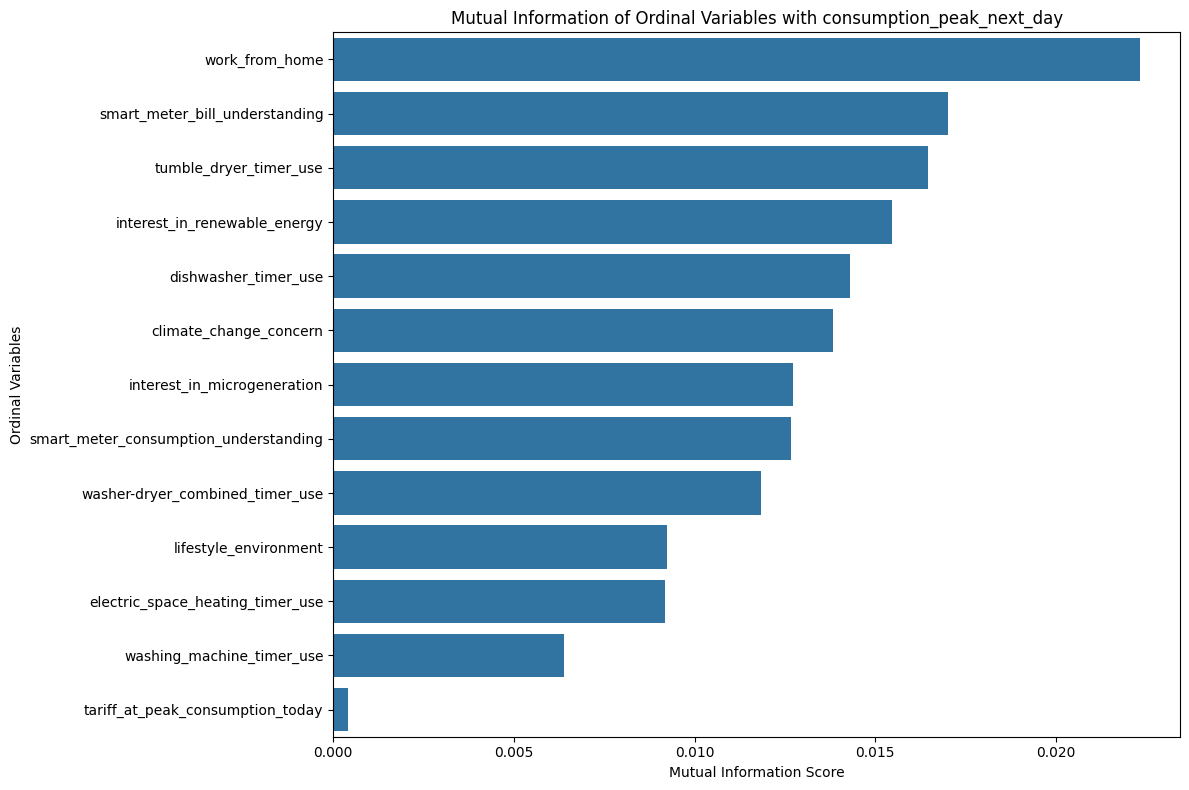

In [13]:
def mutual_info_with_target(df, ordinal_vars, target):
    mi_scores = mutual_info_regression(df[ordinal_vars], df[target])
    mi_df = pd.DataFrame({'Variable': ordinal_vars, 'Mutual Information': mi_scores})
    mi_df = mi_df.sort_values('Mutual Information', ascending=False)
    return mi_df

target_correlations = mutual_info_with_target(result_df, categorical_vars, 'consumption_peak_next_day')

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Mutual Information', y='Variable', data=target_correlations)
plt.title('Mutual Information of Ordinal Variables with consumption_peak_next_day')
plt.xlabel('Mutual Information Score')
plt.ylabel('Ordinal Variables')
plt.tight_layout()
plt.savefig('mutual_information_plot.png')
plt.show()

# A few more visualizations for exploration (Only those that appear on the report)

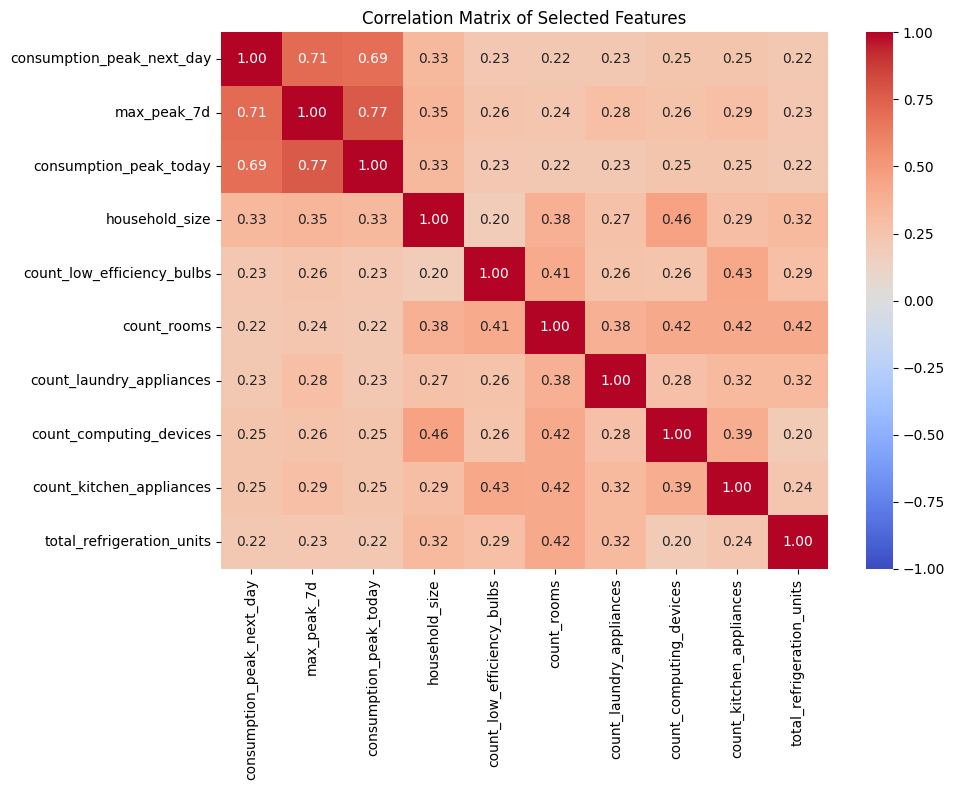

In [14]:
# Correlation matrix with a few selected variables
selected_columns = [
    'consumption_peak_next_day',
    'max_peak_7d',
    'consumption_peak_today',
    'household_size',
    'count_low_efficiency_bulbs',
    'count_rooms',
    'count_laundry_appliances',
    'count_computing_devices',
    'count_kitchen_appliances',
    'total_refrigeration_units'
]

plt.figure(figsize=(10, 8))
sns.heatmap(result_df[selected_columns].corr(), annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Selected Features')
plt.tight_layout()
plt.savefig('selected_features_correlation_matrix.png')
plt.show()

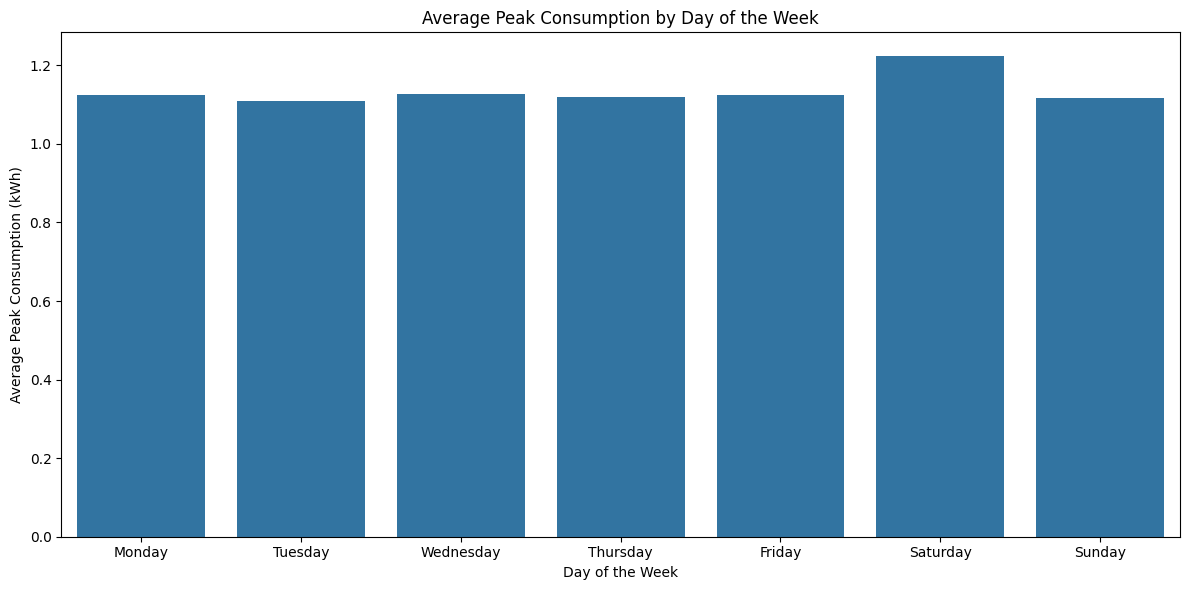

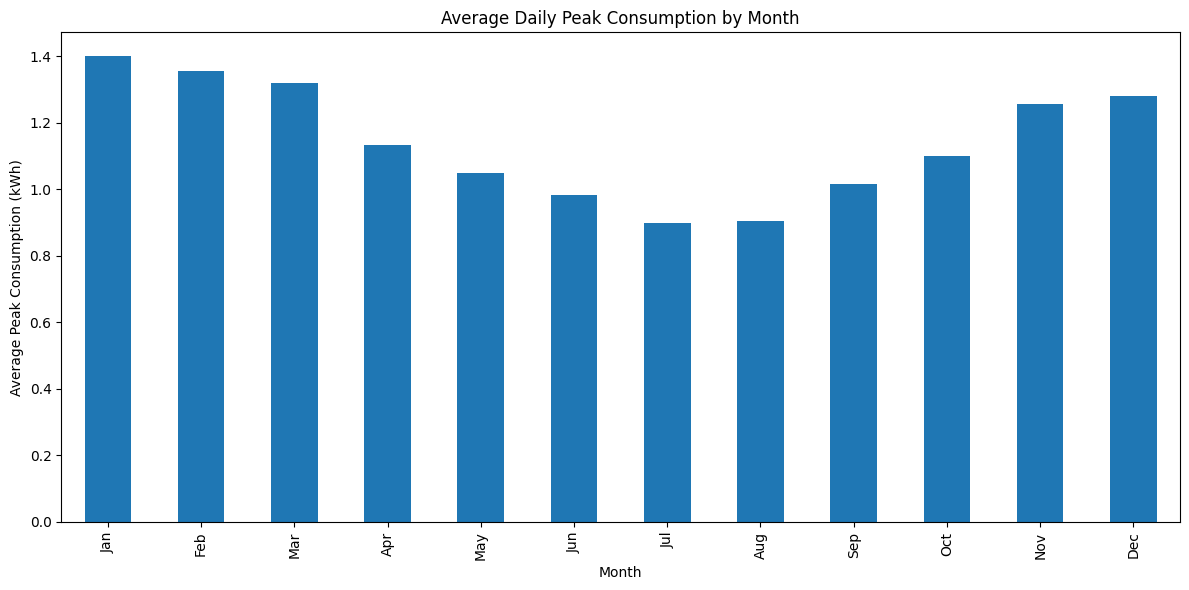

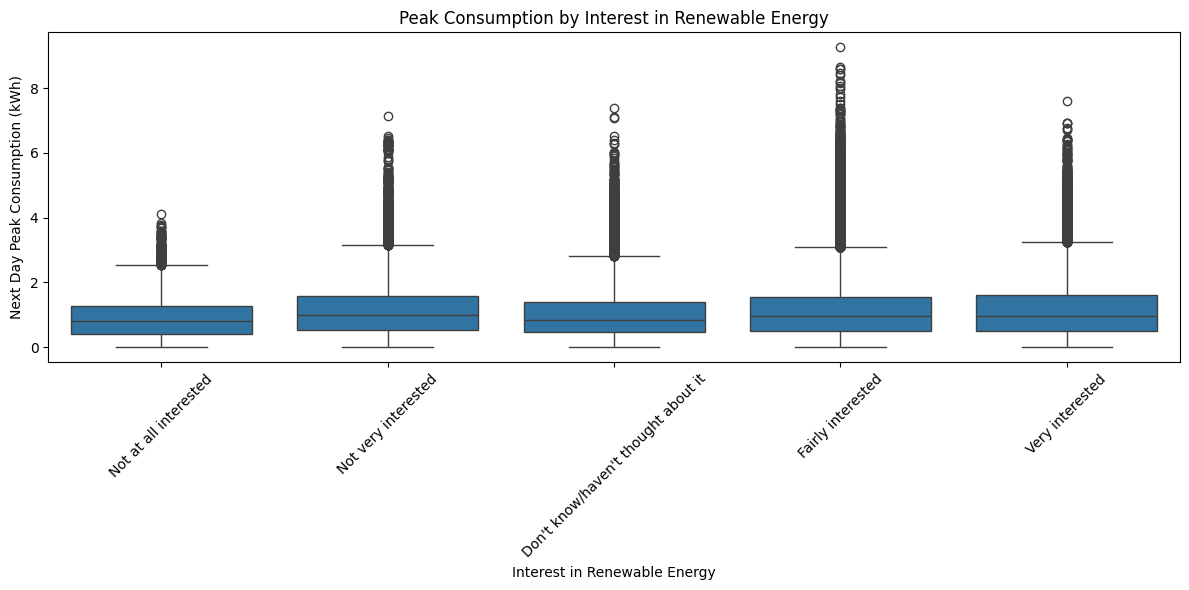

In [15]:
# Create day of the week variable and order
result_df['day_of_week'] = pd.to_datetime(result_df['date']).dt.day_name()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Mean daily peak consumption by day of the week
avg_peak_by_day = result_df.groupby('day_of_week')['consumption_peak_next_day'].mean().reindex(days_order)
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_peak_by_day.index, y=avg_peak_by_day.values, order=days_order)
plt.title('Average Peak Consumption by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Peak Consumption (kWh)')
plt.tight_layout()
plt.show()

# Mean daily peak consumption by month
result_df['month'] = pd.to_datetime(result_df['date']).dt.month
monthly_avg_peak = result_df.groupby('month')['consumption_peak_next_day'].mean()
plt.figure(figsize=(12, 6))
monthly_avg_peak.plot(kind='bar')
plt.title('Average Daily Peak Consumption by Month')
plt.xlabel('Month')
plt.ylabel('Average Peak Consumption (kWh)')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

# Function to plot boxplot for categorical variables
def plot_boxplot(x, y, data, title, xlabel, ylabel, order=None, rotation=45):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=x, y=y, data=data, order=order)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()

# Mapping for interest in renewable energy
renewable_energy_mapping = {0.0: 'Not at all interested', 1.0: 'Not very interested', 
                            2.0: "Don't know/haven't thought about it", 
                            3.0: 'Fairly interested', 4.0: 'Very interested'}

# Create mapped column for plotting
result_df['interest_in_renewable_energy_mapped'] = result_df['interest_in_renewable_energy'].map(renewable_energy_mapping)

# Plot boxplot for interest in renewable energy
plot_boxplot('interest_in_renewable_energy_mapped', 'consumption_peak_next_day', result_df, 
             'Peak Consumption by Interest in Renewable Energy', 
             'Interest in Renewable Energy', 'Next Day Peak Consumption (kWh)',
             order=[renewable_energy_mapping[k] for k in sorted(renewable_energy_mapping.keys())])

# Clean up temporary columns
result_df.drop(['day_of_week', 'month', 'interest_in_renewable_energy_mapped'], axis=1, inplace=True)

### Key Findings:
### 1. The relationship between temperature and peak consumption is non-linear, with higher peaks observed at colder temperatures.
### 2. Several features were dropped due to high correlations with other features or low correlation with the target variable.
### 3. Categorical variables showed some correlation with the target variable but not problematically high correlations among themselves.
### 4. Day of the week, holidays, household size, and month all show some relationship with peak consumption.


In [16]:
# Save the full DataFrame
result_df.to_csv('6) daily_consumption_data_full.csv', index=False)
print("Full data saved to '6) daily_consumption_data_full.csv'")

Full data saved to '6) daily_consumption_data_full.csv'
